In [11]:
import torch
from torch import nn
import torch.optim as optim
import os

from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import torchvision
from torchvision import datasets,models
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset, random_split
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cpu


In [13]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("maysee/mushrooms-classification-common-genuss-images")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mushrooms-classification-common-genuss-images' dataset.
Path to dataset files: /kaggle/input/mushrooms-classification-common-genuss-images


In [14]:
print("Contents of dataset directory:")
for item in os.listdir(path):
    print(f"  {item}")

Contents of dataset directory:
  Mushrooms
  mushrooms


In [15]:
mushrooms_path = os.path.join(path, "Mushrooms")

# трансформации с аугментацией
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Загружаем весь dataset
full_dataset = datasets.ImageFolder(root=mushrooms_path, transform=transform)

# Разделяем на train/test
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size,test_size])

# Создаем DataLoader
num_workers = min(4, os.cpu_count())

train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,
    persistent_workers=True if num_workers > 0 else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False
)

print(f"Total classes: {len(full_dataset.classes)}")
print(f"Classes: {full_dataset.classes}")
print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Total classes: 9
Classes: ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']
Train samples: 5371
Test samples: 1343


In [16]:
class MushroomClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MushroomClassifier, self).__init__()
        self.model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

        for param in list(self.model.parameters())[:-20]:
            param.requires_grad = False

        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.model.classifier[1].in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [17]:
def train_mushroom(net, train_loader, device, num_epochs=15, learning_rate=0.001):
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, weight_decay=1e-4)
    loss_function = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    acc_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        net.train()
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = outputs.max(1)
            batch_total = labels.size(0)
            batch_correct = predicted.eq(labels).sum().item()

            total += batch_total
            correct += batch_correct

            pbar.set_postfix({
                'Loss': f'{running_loss/len(pbar):.4f}',
                'Acc': f'{correct/total:.2%}'
            })

        epoch_acc = correct/total
        acc_history.append(epoch_acc)

        scheduler.step(running_loss/len(train_loader))

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {epoch_acc:.2%}, LR: {optimizer.param_groups[0]["lr"]:.6f}')

    return acc_history

In [18]:
# Функция оценки
def evaluate_acc(net, test_loader, device):
    net.eval()
    total = 0
    correct = 0

    with torch.no_grad():
        for batch_num, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = net(inputs)
            _, predicted = outputs.max(1)

            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct/total
    return acc

In [19]:
# Функция визуализации
def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.show()

Training samples: 5371
Test samples: 1343
Batch size: 32
Epochs: 10
Architecture:
MushroomClassifier(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1

Epoch 1/10: 100%|██████████| 336/336 [09:13<00:00,  1.65s/it, Loss=2.0024, Acc=28.67%]


Epoch 1/10, Loss: 2.0024, Train Acc: 28.67%, LR: 0.010000


Epoch 2/10: 100%|██████████| 336/336 [09:08<00:00,  1.63s/it, Loss=1.6059, Acc=45.17%]


Epoch 2/10, Loss: 1.6059, Train Acc: 45.17%, LR: 0.010000


Epoch 3/10: 100%|██████████| 336/336 [09:16<00:00,  1.66s/it, Loss=1.3362, Acc=53.84%]


Epoch 3/10, Loss: 1.3362, Train Acc: 53.84%, LR: 0.010000


Epoch 4/10: 100%|██████████| 336/336 [09:14<00:00,  1.65s/it, Loss=1.1703, Acc=59.43%]


Epoch 4/10, Loss: 1.1703, Train Acc: 59.43%, LR: 0.010000


Epoch 5/10: 100%|██████████| 336/336 [09:28<00:00,  1.69s/it, Loss=1.0430, Acc=64.66%]


Epoch 5/10, Loss: 1.0430, Train Acc: 64.66%, LR: 0.010000


Epoch 6/10: 100%|██████████| 336/336 [09:22<00:00,  1.67s/it, Loss=0.9728, Acc=65.95%]


Epoch 6/10, Loss: 0.9728, Train Acc: 65.95%, LR: 0.010000


Epoch 7/10: 100%|██████████| 336/336 [09:09<00:00,  1.64s/it, Loss=0.8839, Acc=68.80%]


Epoch 7/10, Loss: 0.8839, Train Acc: 68.80%, LR: 0.010000


Epoch 8/10: 100%|██████████| 336/336 [09:04<00:00,  1.62s/it, Loss=0.8246, Acc=71.68%]


Epoch 8/10, Loss: 0.8246, Train Acc: 71.68%, LR: 0.010000


Epoch 9/10: 100%|██████████| 336/336 [09:15<00:00,  1.65s/it, Loss=0.7805, Acc=72.43%]


Epoch 9/10, Loss: 0.7805, Train Acc: 72.43%, LR: 0.010000


Epoch 10/10: 100%|██████████| 336/336 [09:22<00:00,  1.67s/it, Loss=0.7460, Acc=73.88%]

Epoch 10/10, Loss: 0.7460, Train Acc: 73.88%, LR: 0.010000



Test Accuracy: 75.87%


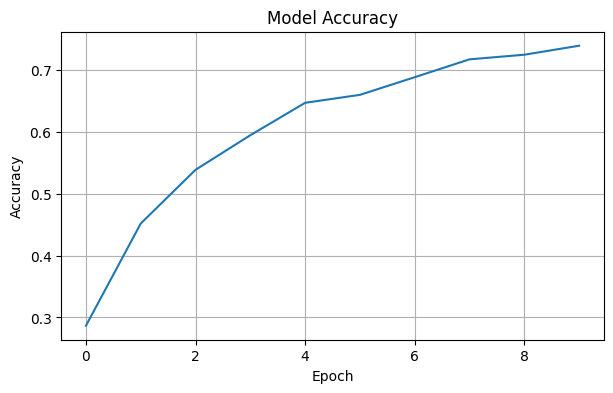

In [20]:
batch_size = 32
epochs = 10
lr = 0.01

print(f"Training samples: {len(train_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")
print(f"Batch size: {batch_size}")
print(f"Epochs: {epochs}")

# Создание модели
net = MushroomClassifier(num_classes=10)
net = net.to(device)
print("Architecture:")
print(net)

# Обучение
hist_net = train_mushroom(net, train_loader, device, epochs, lr)

# Оценка
net_acc = evaluate_acc(net, test_loader, device)
print(f'\nTest Accuracy: {net_acc:.2%}')

# Визуализация
print_history(hist_net, "Model Accuracy")